In [1]:
import numpy as np
import tables
import matplotlib.pyplot as plt

In [2]:
path = "/home/zelenyy/data/satellite/MCMC_1_69/mcmc_1_69.hdf5"

In [8]:
with tables.open_file(path) as h5file:
    table = h5file.get_node("/sim2100/deposit")
    print(repr(table.attrs))
    data = table.read()
    

/sim2100/deposit._v_attrs (AttributeSet), 21 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0.0,
    FIELD_0_NAME := 'event',
    NROWS := 10000,
    TITLE := 'Deposit in detector cell',
    VERSION := '2.7',
    path := 'sim2100',
    text := '/df/project test\n/df/gdml ../../satellite.gdml\n/satellite/output file\n/satellite/detector single\n\n/gps/particle proton\n/gps/number 1\n/gps/direction -0.49999999999999994 0.0 -0.8660254037844387\n/gps/ene/mono 30.0 MeV\n/gps/position 0.07499999999999998 0. 0.22990381056766582 m\n/run/beamOn 10000\n',
    values_macros_dirX := -0.49999999999999994,
    values_macros_dirZ := -0.8660254037844387,
    values_macros_energy := 30.0,
    values_macros_mode := 'single',
    values_macros_number := 10000,
    values_macros_particle := 'proton',
    values_macros_posX := 0.07499999999999998,
    values_macros_posZ := 0.22990381056766582,
    values_macros_radius := 0.15,
    values_macros_shift := 0,
    values_macros_theta := 30.0,
    values

In [9]:
data.dtype

dtype([('event', '<f4', (100,))])

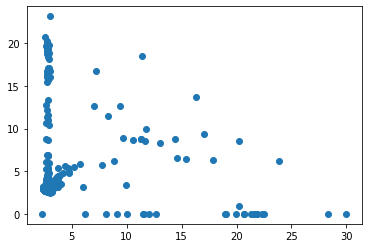

In [10]:
plt.scatter(data["event"][:, 0], data["event"][:,1])

In [11]:
np.all(data[0]==0.0)


/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  """Entry point for launching an IPython kernel.


False

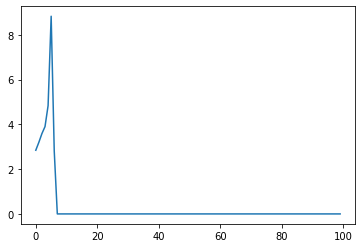

In [12]:
plt.plot(data["event"][0])